In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sig
from scipy.stats import iqr
import math
from scipy.stats import pearsonr
from itertools import permutations
import pandas as pd
from scipy.signal import chebwin
import scipy.special as spc

In [3]:
label=['respiracion','ecg','emg','pulso']
via='/Users/josec/OneDrive/Documentos/MCIB-19-P/data/'
data= np.load(via+'acondicionada_orto.npz')
fs=int(data['sr'])
ts=1/fs
senales=[]
for i in label:
    senales.append(data[i][0:224640])
#z-score
zscore=[]
for i in range(len(senales)):
    zscore.append((senales[i][:]-np.mean(senales[i][:]))/np.std(senales[i][:]))

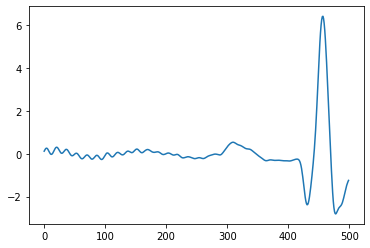

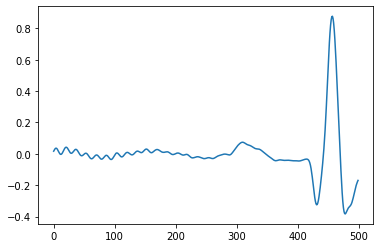

In [4]:
# rescalar -1 a 1
Nsignal=[]
for i in range (len(senales)):
    Nsignal.append(senales[i]/(max(abs(senales[i]))))    
#Comparacion de ecg con distintos reescalados    
plt.plot(zscore[1][0:500])
plt.figure()
plt.plot(Nsignal[1][0:500])
#Mascara para distinguir entre etapas basales y activas
mascara=np.zeros(len(senales[0]))
mascara[0:134476]=1
mascara[134477:152448]=2
mascara[152449:187228]=3
mascara[187229:224660]=4

In [5]:
def N_bins (x):
    dist_y=max(x)-min(x)
    iqrange=iqr(x)
    nbin=math.ceil(dist_y/(2*iqrange*len(x)**(-float(1)/3)))
    return nbin

In [6]:
def histogram(s,lab):
    nbins = np.sqrt(len(s))
    intervals= np.linspace(s.min(),s.max(),nbins+1)
    ancho_b=(s.max()-s.min())/nbins
    left = s[:,np.newaxis] > intervals[:-1][np.newaxis]
    right = s[:,np.newaxis] < intervals[1:][np.newaxis]
    hist = (left*right).sum(axis=0)
    hist= hist/sum(hist)
    plt.bar(intervals[:-1],hist,width=ancho_b,label=lab)
    legend = plt.legend(loc='upper right', shadow=True, fontsize='medium')
    legend.get_frame().set_facecolor('pink') 
    plt.grid(True)
    plt.title(label[i])
    return (intervals[:-1],hist)

C:\Users\josec\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


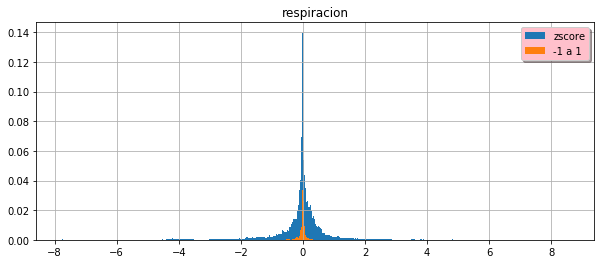

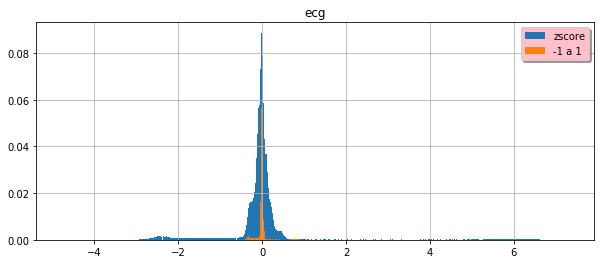

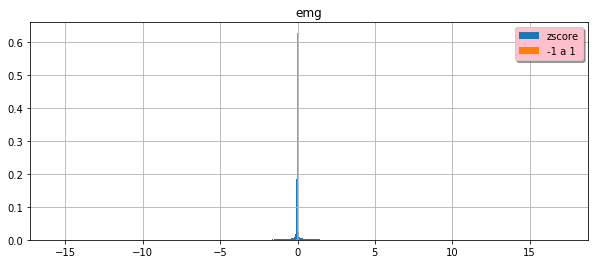

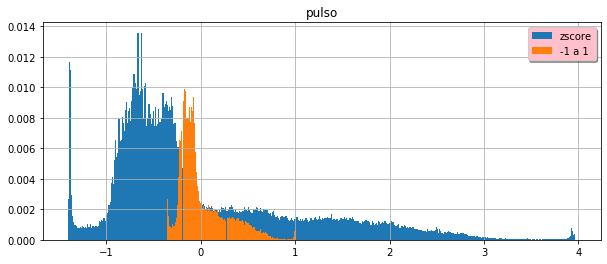

In [7]:
#COMPARACION DE HISTOGRAMAS DE REESCALACIONES
for i in range (len(zscore)):
    plt.figure(figsize=(10,4))
    histogram(zscore[i],'zscore')
    histogram(Nsignal[i],'-1 a 1')

In [8]:
def coef_corr(x,y):
    N=len(x)
    r = np.dot(x,y)/N
    r= r-(np.mean(x)*np.mean(y))
    r= r/np.sqrt(np.var(x)*np.var(y))
    r = max(min(r, 1.0), -1.0)
    df = N-2
    if abs(r) == 1.0:
        prob = 0.0
    else:
        t_squared = r*r * (df / ((1.0 - r) * (1.0 + r)))
        prob = betai(0.5*df, 0.5, df / (df + t_squared))
    return r,prob

In [9]:
def betai(a, b, x):
    x = np.asarray(x)
    x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
    return spc.betainc(a, b, x)

In [10]:
perm=list(permutations(np.arange(0,len(label)),2))
perm=np.asarray(perm)
perm[[3,6,7,9,10,11],:]=99
perm=perm[perm[:,0]!=99]
estado=['basal','acoplamiento','actividad','recuperacion']
coefs = np.zeros((len(perm),4))
pvalue=np.zeros((len(perm),4))
for i in range (len (perm)):
    for j in range(len(estado)):
        r,p= coef_corr(zscore[perm[i,0]][mascara==j+1],zscore[perm[i,1]][mascara==j+1])
        coefs[i,j]=r
        pvalue[i,j]=p
d={'corr basal':coefs[:,0],'corr acoplamiento':coefs[:,1],'corr actividad':coefs[:,2],'corr recuperacion':coefs[:,3]}
print(pd.DataFrame(d))
d2={'pvalue basal':pvalue[:,0],'pvalue acoplamiento':pvalue[:,1],'pvalue actividad':pvalue[:,2],'pvalue recuperacion':pvalue[:,3]}
print(pd.DataFrame(d2))

   corr basal  corr acoplamiento  corr actividad  corr recuperacion
0   -0.000018           0.000390       -0.000193          -0.000100
1    0.002473           0.000010       -0.000016          -0.000570
2   -0.027069          -0.134515       -0.014913           0.020895
3    0.009422           0.063705        0.000637          -0.026291
4   -0.006025           0.004747       -0.000841          -0.004791
5   -0.000283          -0.002157       -0.001172          -0.003440
   pvalue basal  pvalue acoplamiento  pvalue actividad  pvalue recuperacion
0  9.946888e-01         9.583002e-01          0.971345         9.846100e-01
1  3.644266e-01         9.989580e-01          0.997597         9.121509e-01
2  3.141536e-23         2.487632e-73          0.005414         5.305312e-05
3  5.497170e-04         1.251072e-17          0.905455         3.659677e-07
4  2.714191e-02         5.245408e-01          0.875375         3.540928e-01
5  9.174039e-01         7.724318e-01          0.827018         5.058

In [11]:
#Diseño PSD Cruzada
def PSDcruz(matrix,matrix2,sr):
    N1=np.size(matrix,1)
    N2=np.size(matrix,0)
    #rxx=sig.convolve2d(matrix,matrix2,mode='same')
    rxx=matrix
    rxx=rxx*(chebwin(N1,at=100).reshape(1,N1)*np.ones((N2,1)))
    sxx=np.fft.fft(rxx,axis=1)
    ryy=matrix2
    ryy=ryy*(chebwin(N1,at=100).reshape(1,N1)*np.ones((N2,1)))
    syy=np.fft.fft(ryy,axis=1)
    sxy=np.conjugate(sxx)*syy
    mag_sxx=sxy[:,0:N1//2]
    mag_sxx=np.mean(mag_sxx,0)
    F=np.linspace(0,sr//2,len(mag_sxx))
    return F,mag_sxx

In [12]:
def PSD(matrix,sr):
    N1=np.size(matrix,1)
    N2=np.size(matrix,0)
    #rxx=sig.convolve2d(matrix,matrix,mode='same')
    rxx=matrix
    rxx=rxx*(chebwin(N1,at=100).reshape(1,N1)*np.ones((N2,1)))
    sxx=np.fft.fft(rxx,axis=1)
    sxx=np.conjugate(sxx)*sxx
    mag_sxx=sxx[:,0:N1//2]
    mag_sxx=np.mean(mag_sxx,0)
    F=np.linspace(0,sr//2,len(mag_sxx))
    return F,mag_sxx

In [13]:
def coherence(x,y,v,sr):
    N=len(x)
    if N % v!=0:
        Nzeros=v-(N % v)
        x=np.append(x,np.zeros(Nzeros))
        y=np.append(y,np.zeros(Nzeros)) # agregar ceros para mejorar la estimación, y para que el reshape se pueda hacer
    else:
        x=x
        y=y
    Nv=len(x)//v
    matrix1=x.reshape(v,Nv)
    matrix2=y.reshape(v,Nv)
    F,sxy=PSDcruz(matrix1,matrix2,sr)
    F,sxx=PSD(matrix1,sr)
    F,syy=PSD(matrix2,sr)
    Cxy = np.abs(sxy)**2 /(sxx * syy)
    plt.plot(F[0:len(F)//4],10*np.log10(Cxy[0:len(F)//4]),label=estado[j])
    legend = plt.legend(loc='upper right', shadow=True, fontsize='small')
    legend.get_frame().set_facecolor('pink') 
    plt.xlabel('Hz')
    plt.ylabel('dBs')
    plt.title('coherencia entre {0} y {1}'.format(label[perm[i,0]],label[perm[i,1]]))
    plt.grid()
    return F,Cxy

C:\Users\josec\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


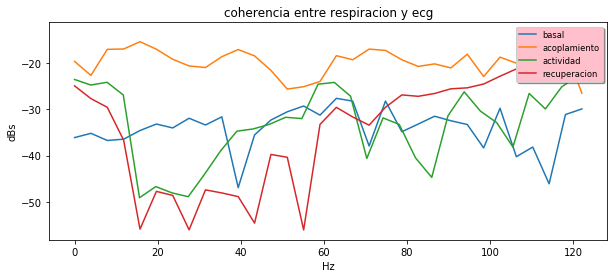

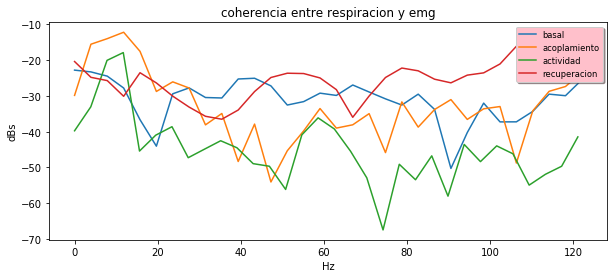

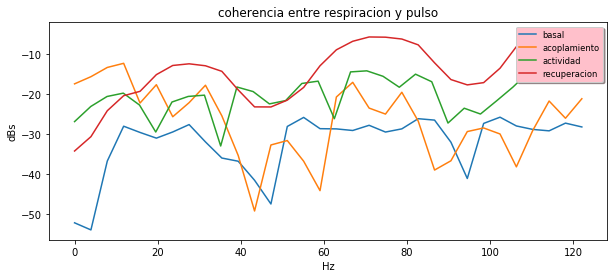

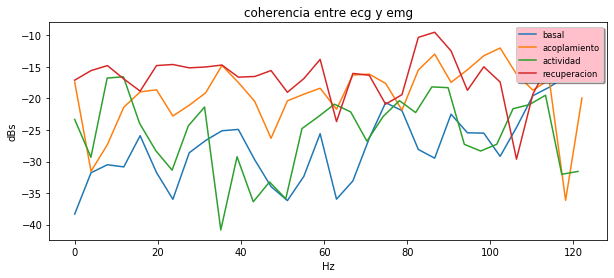

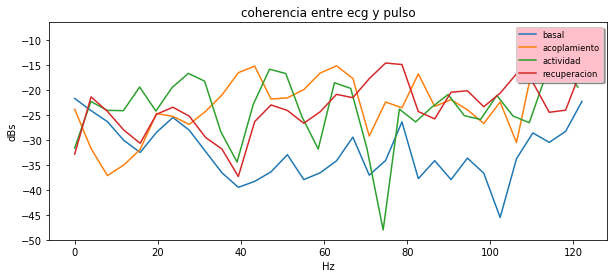

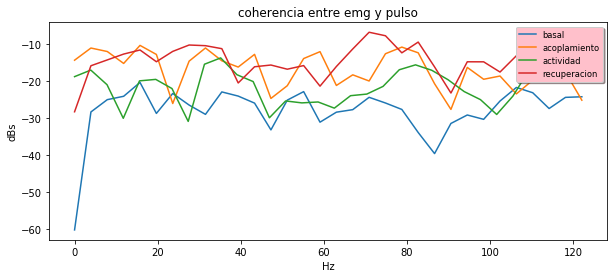

In [14]:
#coherencia espectral

for i in range (len(perm)):
    plt.figure(figsize=(10,4))
    for j in range (len(estado)):
        coherence(zscore[perm[i,0]][mascara==j+1],zscore[perm[i,1]][mascara==j+1],len(zscore[perm[i,1]][mascara==j+1])//256,sr=fs)      
#find peaks of ECG y pulso

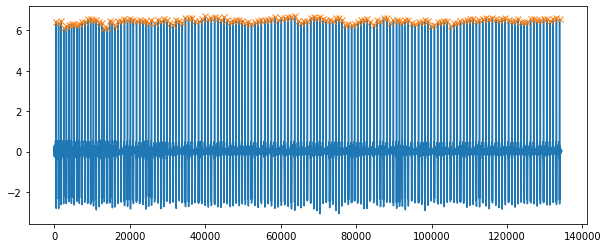

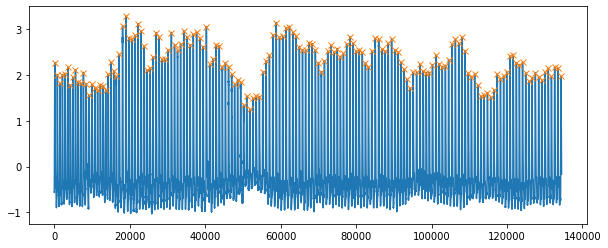

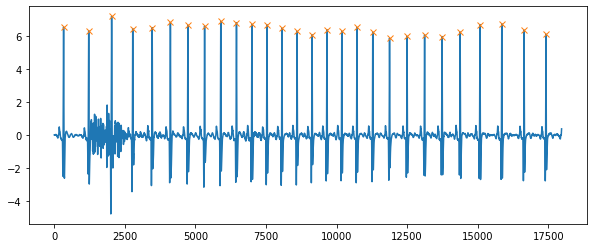

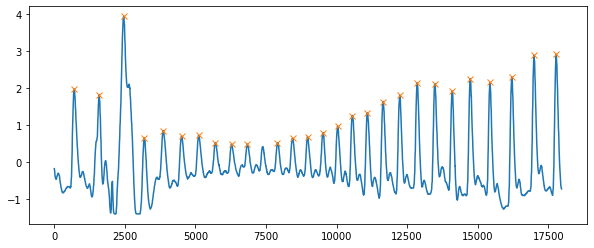

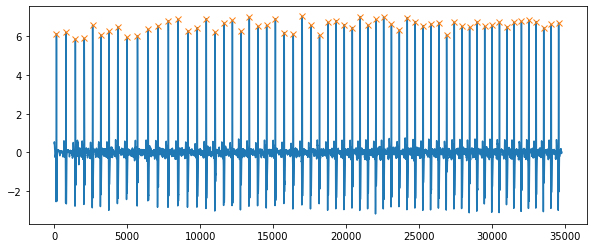

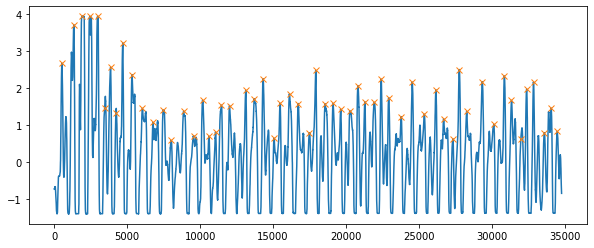

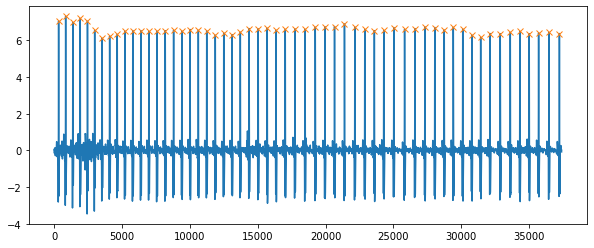

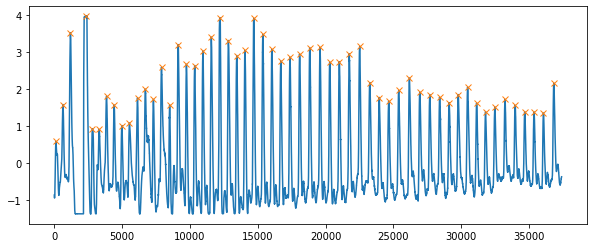

In [15]:
fRRecg=[]
fRRp=[]
for i in range (len(estado)):
    plt.figure(figsize=(10,4))
    x=zscore[1][mascara==i+1]
    x2=zscore[3][mascara==i+1]
    plt.plot(x)
    peak, _ = sig.find_peaks(x,distance=.4/ts,height=(2*np.sqrt(np.dot(x,x)/len(x)), None))
    plt.plot(peak, x[peak], "x")
    fRRecg.append((1/(np.diff(peak)*ts))*60)
    plt.figure(figsize=(10,4))
    plt.plot(x2)
    peaks, _ = sig.find_peaks(x2,distance=.4/ts,height=(np.sqrt(np.dot(x2,x2)/len(x2))/2, None))
    plt.plot(peaks, x2[peaks], "x")
    fRRp.append((1/(np.diff(peaks)*ts))*60)


In [ ]:
# correlacion entre frecuencias cardiacas    
for i in range(len(fRRp)):
    r,p=coef_corr(fRRp[i][:min(len(fRRp[i]),len(fRRecg[i]))],fRRecg[i][:min(len(fRRp[i]),len(fRRecg[i]))])
    print('En el estado {0} se tuvo un coef de {1} y un p valor de {2}'.format(estado[i],r,p))